In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [18]:
df = pd.read_csv("aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


In [19]:
df = df.drop("enrollee_id", axis=1)

In [21]:
df['gender'] = df['gender'].fillna('Unknown')
df['enrolled_university'] = df['enrolled_university'].fillna('Unknown')
df['education_level'] = df['education_level'].fillna('Unknown')
df['major_discipline'] = df['major_discipline'].fillna('Unknown')
df['experience'] = df['experience'].fillna('Unknown')
df['company_size'] = df['company_size'].fillna('Unknown')
df['company_type'] = df['company_type'].fillna('Unknown')
df['last_new_job'] = df['last_new_job'].fillna('Unknown')

In [22]:
label_cols = [
    'gender','relevent_experience','enrolled_university',
    'education_level','major_discipline','experience',
    'company_size','company_type','last_new_job','city'
]

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [23]:
scaler = StandardScaler()
df[['city_development_index', 'training_hours']] = scaler.fit_transform(
    df[['city_development_index', 'training_hours']]
)

In [24]:
X = df.drop("target", axis=1)
y = df["target"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (15326, 12)
Testing shape: (3832, 12)


In [39]:
# Save full preprocessed dataset
df.to_csv("preprocessed_full.csv", index=False)
print("✅ Preprocessed full dataset saved as preprocessed_full.csv")

# Save training set
train_data = X_train.copy()
train_data["target"] = y_train
train_data.to_csv("train_preprocessed.csv", index=False)
print("✅ Training set saved as train_preprocessed.csv")

# Save test set
test_data = X_test.copy()
test_data["target"] = y_test
test_data.to_csv("test_preprocessed.csv", index=False)
print("✅ Test set saved as test_preprocessed.csv")

✅ Preprocessed full dataset saved as preprocessed_full.csv
✅ Training set saved as train_preprocessed.csv
✅ Test set saved as test_preprocessed.csv


In [28]:
rf_model = RandomForestClassifier(
    n_estimators=200,   
    max_depth=None,     
    random_state=42,
    n_jobs=-1           
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
y_pred = rf_model.predict(X_test)

In [30]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.7792275574112735

Confusion Matrix:
[[2534  346]
 [ 500  452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2880
           1       0.57      0.47      0.52       952

    accuracy                           0.78      3832
   macro avg       0.70      0.68      0.69      3832
weighted avg       0.77      0.78      0.77      3832



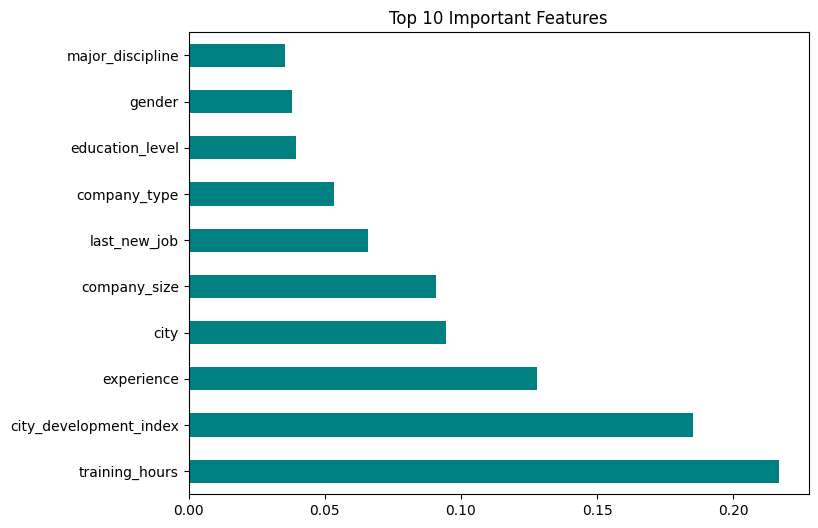

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh', figsize=(8,6), color="teal")
plt.title("Top 10 Important Features")
plt.show()

In [33]:
param_grid = {
    'n_estimators': [100, 200, 300],       
    'max_depth': [None, 10, 20, 30],       
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4],         
    'max_features': ['sqrt', 'log2']       
}

In [34]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                
    scoring='f1',        
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [35]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 Score: 0.577040503605934


In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_best = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Test Accuracy: 0.7891440501043842

Confusion Matrix:
 [[2488  392]
 [ 416  536]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      2880
           1       0.58      0.56      0.57       952

    accuracy                           0.79      3832
   macro avg       0.72      0.71      0.72      3832
weighted avg       0.79      0.79      0.79      3832



In [37]:
import joblib
joblib.dump(best_rf, "random_forest_tuned.pkl")

['random_forest_tuned.pkl']

In [40]:
import joblib
import pandas as pd

# Load trained model
model = joblib.load("random_forest_tuned.pkl")

# Load some already preprocessed data (like X_test from CSV)
test_data = pd.read_csv("test_preprocessed.csv")

# Predict
predictions = model.predict(test_data.drop("target", axis=1))
print(predictions[:10])

[0 0 0 1 0 0 0 0 0 0]
